This notebook is used to prepare a critical difference plot and a Pareto frontier analysis plot.


In [1]:
cd ..

/storage/store3/soda/rcappuzz/retrieve-merge-predict/bench


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import polars as pl
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from src.utils.logging import read_and_process
from src.utils import plotting, constants
from src.utils.critical_difference_plot import critical_difference_diagram
import numpy as np
import seaborn as sns

sns.set_context("talk")
plt.style.use("seaborn-v0_8-talk")

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator


def major_gigabyte_formatter(x, pos):
    return f"{x/1e3:.0f} GB"


def minor_gigabyte_formatter(x, pos):
    return f"{x/1e3:.0f}"


def major_time_formatter(x, pos):
    # return f"{x/60:.0f}min"
    if x  > 60:
        return f"{x/60:.0f}min"
    else:
        return f"{x:.0f}s"

# Create a FuncFormatter object
major_gb_formatter = FuncFormatter(major_gigabyte_formatter)
minor_gb_formatter = FuncFormatter(minor_gigabyte_formatter)

# Fixed locators
major_time_locator = FixedLocator([10, 120, 600, 3600])
gb_locator = FixedLocator([2000, 3000, 4000, 5000, 7000, 10000])

In [13]:
df = pl.read_parquet("results/temp_results_retrieval.parquet")
df = df.with_columns(
    pl.when(pl.col("prediction_metric") < -1)
    .then(-1)
    .otherwise(pl.col("prediction_metric"))
    .alias("y")
)

## Pareto front


In [83]:
# Setting constants
hues = {0: "estimator", 1: "chosen_model", 2: "jd_method"}
titles = {0: "Selector", 1: "Prediction Model", 2: "Retrieval method"}
hue_order = {
    "estimator": ["full_join", "highest_containment", "stepwise_greedy_join", "best_single_join"],
    "chosen_model": ["catboost", "ridgecv", "resnet", "realmlp"],
    "jd_method": ["exact_matching", "starmie", "minhash", "minhash_hybrid"],
    "aggregation": ["first", "mean", "dfs"],
}
palettes = {0: "tab10", 1: "tab10", 2: "tab10"}

In [14]:
# Load retrieval stats
df_retrieval = pl.read_csv("stats/stats_retrieval_plot.csv")
df_retrieval = df_retrieval.rename({"index_name": "jd_method"}).filter(
    pl.col("data_lake_version") != "wordnet_vldb_50"
)

_d = df_retrieval.with_columns(
    cat=pl.col("jd_method").cast(pl.Categorical).cast(int)
).with_columns(
    cat=pl.when((pl.col("cat") == 1) | (pl.col("cat") == 2))
    .then(1)
    .otherwise(pl.col("cat"))
)
_d = _d.join(
    _d.group_by(["data_lake_version", "cat"]).agg(
        pl.mean("time_create", "time_save", "time_load")
    ),
    on=["data_lake_version", "cat"],
)

In [15]:
stats_retrieval = (
    _d.with_columns(
        time_retrieval=pl.when(pl.col("jd_method") != "starmie")
        .then(
            pl.sum_horizontal(
                [
                    "time_create_right",
                    "time_save_right",
                    "time_load_right",
                    "time_query",
                ]
            )
        )
        .otherwise("total_retrieval")
    )
    .group_by(["data_lake_version", "jd_method"])
    .agg(pl.mean("peak_memory"), pl.mean("time_retrieval"))
)

df_ = (
    df.join(
        stats_retrieval,
        left_on=["target_dl", "jd_method"],
        right_on=["data_lake_version", "jd_method"],
    )
    .with_columns(max_ram=pl.max_horizontal("peak_fit", "peak_predict", "peak_memory"))
    .with_columns(total_time=pl.col("time_run") + pl.col("time_retrieval"))
    .filter(pl.col("estimator") != "nojoin")
)

res = df_.group_by(keys).agg(
    pl.mean("total_time"),
    pl.mean("y"),
    pl.mean("time_run"),
    pl.mean("max_ram"),
    pl.mean("peak_fit"),
)

### Combined

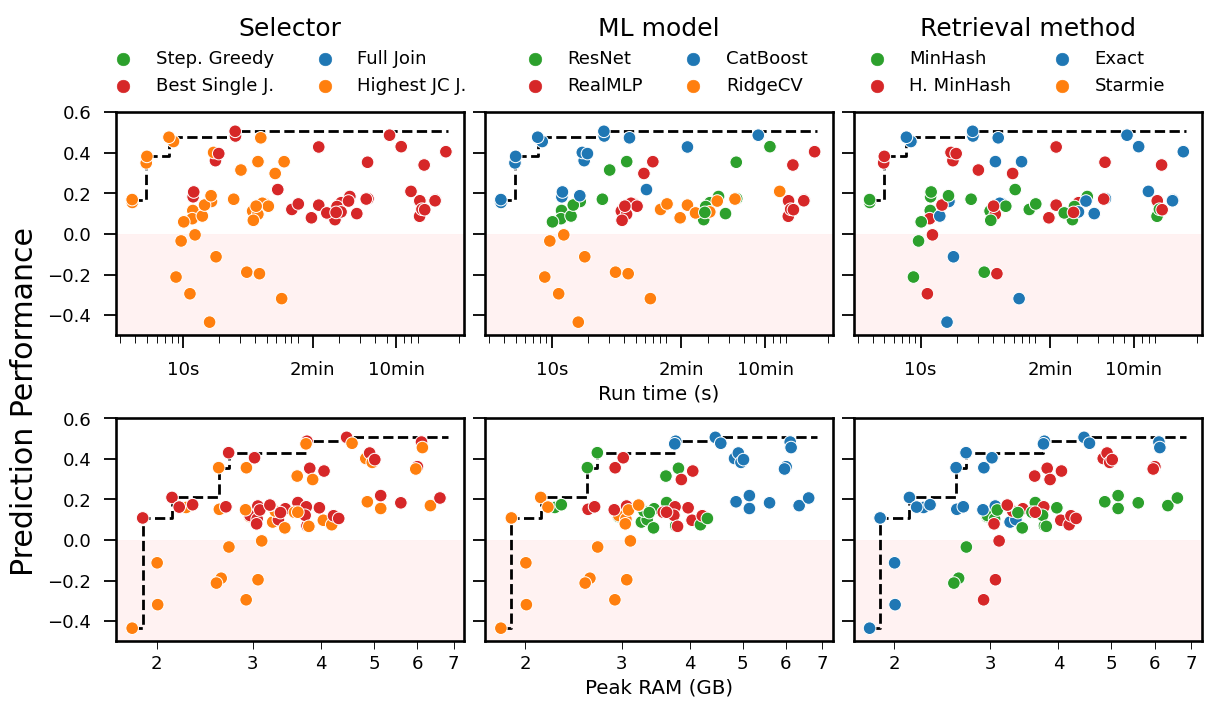

In [68]:
fig, axs = plt.subplots(
    2,
    3,
    sharey=True,
    layout="constrained",
    figsize=(12, 6),
    gridspec_kw={"wspace": 0.01},
)


# Time
data = res.to_pandas()
y_var = "y"

map_xlabel = {
    "time_run": "Run time (s)",
    "peak_fit": "Peak RAM (GB)",
    "max_ram": "Peak RAM (GB)",
    "total_time": "Retrieval + Training time (s)",
}

plot_vars = ["time_run", "peak_fit"]

for idx_1 in range(2):
    x_var = plot_vars[idx_1]
    for idx_2 in range(3):
        var_ = hues[idx_2]
        ax = axs[idx_1][idx_2]
        ax.set_ylim([-0.5, 0.6])
        ax.axhspan(0, -0.5, zorder=0, alpha=0.05, color="red")

        if idx_2 == 1:
            _xlabel = map_xlabel[x_var]
        else:
            _xlabel = ""
        h, l = plotting.pareto_frontier_plot(
            data,
            x_var,
            y_var,
            hue_var=hues[idx_2],
            palette="tab10",
            hue_order=hue_order[idx_2],
            ax=ax,
            ax_title="",
            ax_xlabel=_xlabel,
        )
        l = [constants.LABEL_MAPPING[hues[idx_2]][_] for _ in l]

        # first row
        if idx_1 == 0:
            ax.set_xscale("log")

            ax.legend(
                h,
                l,
                loc="upper center",
                bbox_to_anchor=(0.5, 1.5),
                title=constants.LABEL_MAPPING["variables"][var_],
                ncols=2,
                mode="expand",
                edgecolor="white",
            )
            ax.xaxis.set_major_formatter(major_time_formatter)
            ax.xaxis.set_major_locator(major_time_locator)
        else:
            ax.get_legend().remove()
            # ax.legend([], [], edgecolor="white")
            ax.set_xscale("log")

            ax.xaxis.set_major_formatter(major_gb_formatter)
            ax.xaxis.set_minor_formatter(minor_gb_formatter)


fig.supylabel("Prediction Performance")

fig.savefig("images/pareto_comparison.png")
fig.savefig("images/pareto_comparison.pdf")

### Aggregation

In [23]:

df = pl.read_parquet("results/temp_results_aggregation.parquet")
df = df.with_columns(
    pl.when(pl.col("prediction_metric") < -1)
    .then(-1)
    .otherwise(pl.col("prediction_metric"))
    .alias("y")
).filter(pl.col("estimator") != "nojoin")

keys = ["jd_method", "estimator", "aggregation", "chosen_model"]
exp_keys = ["base_table", "target_dl"]
names = df.unique(keys).select(keys).sort(keys).with_row_index("model")
df = df.join(names, on=keys, how="left")
experiments = (
    df.unique(exp_keys).select(exp_keys).sort(exp_keys).with_row_index("experiment")
)
df = df.join(experiments, on=exp_keys, how="left")

res = df.group_by(keys).agg(
    pl.mean("y"),
    pl.mean("time_run"),
    pl.mean("peak_fit"),
)
data = res.to_pandas()

In [24]:
df_ = (
    df.join(
        stats_retrieval,
        left_on=["target_dl", "jd_method"],
        right_on=["data_lake_version", "jd_method"],
    )
    .with_columns(max_ram=pl.max_horizontal("peak_fit", "peak_predict", "peak_memory"))
    .with_columns(total_time=pl.col("time_run") + pl.col("time_retrieval"))
    .filter(pl.col("estimator") != "nojoin")
)

res = df.group_by(keys).agg(
    pl.mean("total_time"),
    pl.mean("y"),
    pl.mean("time_run"),
    pl.mean("max_ram"),
    pl.mean("peak_fit"),
)

NameError: name 'stats_retrieval' is not defined

(2.65058689824341, 3220.54198523502)
(2.608144337950073, 4520.098370209144)
(2.5643108862148685, 6452.496142140912)
(2.519078392302524, 9376.410533174372)


Text(0.5, 0.01, 'Time run (s)')

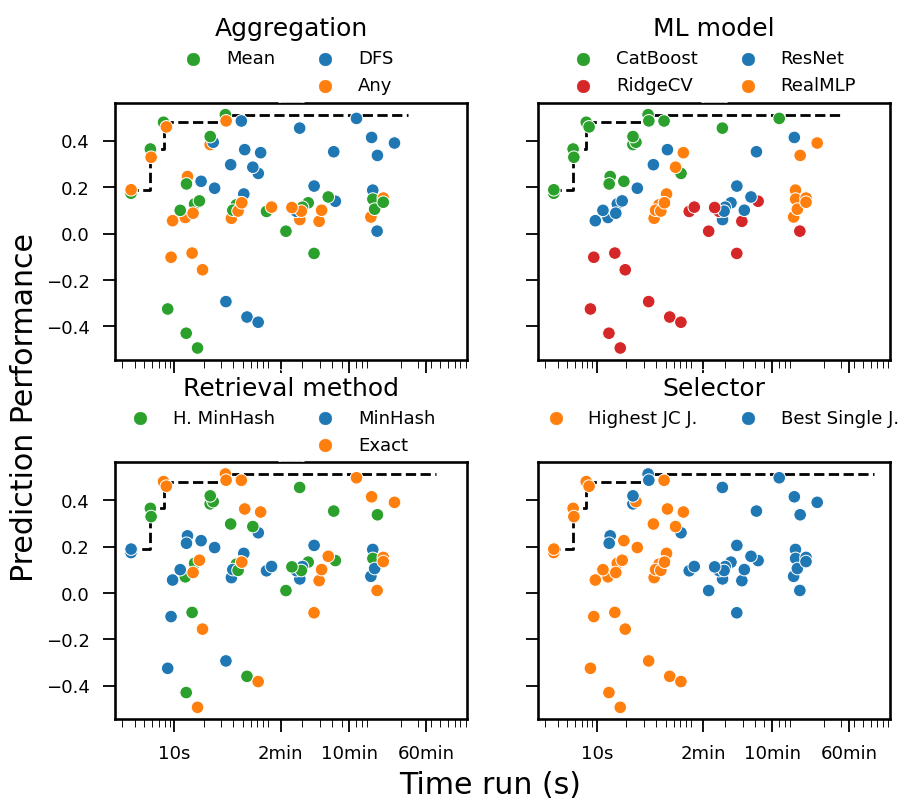

In [25]:
fig, axs = plt.subplots(2, 2, squeeze=True, sharey=True, sharex=True, figsize=(10, 8), gridspec_kw={"hspace":.4} )

# axs[0].set_xscale("log")
# axs[0].set_ylabel("Prediction performance")

variable = "time_run"
x = res[variable]
y = res["y"]


groups = ["aggregation", "chosen_model", "jd_method", "estimator"]
for pl_id in range(4):
    ax = axs[pl_id//2][pl_id%2]
    ax.set_xscale("log")
    idx_ = pl_id
    xs = np.array(x)
    ys = np.array(y)
    perm = np.argsort(xs)
    xs = xs[perm]
    ys = ys[perm]
    sns.scatterplot(
        data=res.to_pandas(),
        x=variable,
        y="y",
        hue=groups[idx_],
        ax=ax,
        palette="tab10",
        # hue_order=hue_order[idx],
    )

    xs_pareto = [xs[0], xs[0]]
    ys_pareto = [ys[0], ys[0]]
    for i in range(1, len(xs)):
        if ys[i] > ys_pareto[-1]:
            xs_pareto.append(xs[i])
            ys_pareto.append(ys_pareto[-1])
            xs_pareto.append(xs[i])
            ys_pareto.append(ys[i])
    xs_pareto.append(ax.get_xlim()[1])
    ys_pareto.append(ys_pareto[-1])

    ax.plot(xs_pareto, ys_pareto, "--", color="k", linewidth=2, zorder=0.8)
    ax.set_ylabel("")
    ax.set_xlabel("")

    print(ax.get_xlim())
    h, l = ax.get_legend_handles_labels()
    l = [constants.LABEL_MAPPING[groups[pl_id]][_] for _ in l]

    ax.legend(
        h,
        l,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.4),
        title=constants.LABEL_MAPPING["variables"][groups[pl_id]],
        ncols= 2,
        mode="expand",
        edgecolor="white",
        # columnspacing=50
    )
    ax.xaxis.set_major_formatter(major_time_formatter)
    ax.xaxis.set_major_locator(major_time_locator)

fig.supylabel("Prediction Performance")
fig.supxlabel("Time run (s)")


(1630.918195102413, 7710.37532041714)
(1625.170377030446, 8303.75267940599)
(1619.1569683052744, 8976.008117096997)
(1612.8668349193447, 9740.528227937575)


Text(0.5, 0.01, 'Time run (s)')

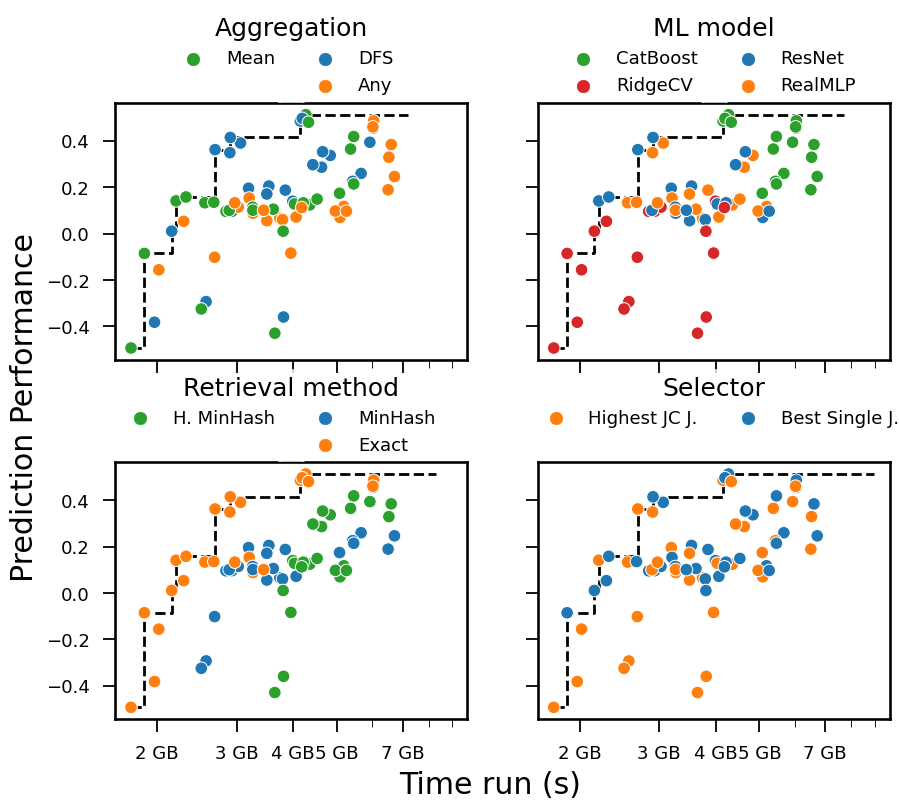

In [26]:
from matplotlib.ticker import NullFormatter

fig, axs = plt.subplots(2, 2, squeeze=True, sharey=True, sharex=True, figsize=(10, 8), gridspec_kw={"hspace":.4} )

# axs[0].set_xscale("log")
# axs[0].set_ylabel("Prediction performance")

variable = "peak_fit"
x = res[variable]
y = res["y"]


groups = ["aggregation", "chosen_model", "jd_method", "estimator"]
for pl_id in range(4):
    ax = axs[pl_id//2][pl_id%2]
    ax.set_xscale("log")
    idx_ = pl_id
    xs = np.array(x)
    ys = np.array(y)
    perm = np.argsort(xs)
    xs = xs[perm]
    ys = ys[perm]
    sns.scatterplot(
        data=res.to_pandas(),
        x=variable,
        y="y",
        hue=groups[idx_],
        ax=ax,
        palette="tab10",
        # hue_order=hue_order[idx],
    )

    xs_pareto = [xs[0], xs[0]]
    ys_pareto = [ys[0], ys[0]]
    for i in range(1, len(xs)):
        if ys[i] > ys_pareto[-1]:
            xs_pareto.append(xs[i])
            ys_pareto.append(ys_pareto[-1])
            xs_pareto.append(xs[i])
            ys_pareto.append(ys[i])
    xs_pareto.append(ax.get_xlim()[1])
    ys_pareto.append(ys_pareto[-1])

    ax.plot(xs_pareto, ys_pareto, "--", color="k", linewidth=2, zorder=0.8)
    ax.set_ylabel("")
    ax.set_xlabel("")

    print(ax.get_xlim())
    h, l = ax.get_legend_handles_labels()
    l = [constants.LABEL_MAPPING[groups[pl_id]][_] for _ in l]

    ax.legend(
        h,
        l,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.4),
        title=constants.LABEL_MAPPING["variables"][groups[pl_id]],
        ncols= 2,
        mode="expand",
        edgecolor="white",
        # columnspacing=50
    )
    ax.xaxis.set_major_formatter(major_gb_formatter)
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.xaxis.set_major_locator(gb_locator)


fig.supylabel("Prediction Performance")
fig.supxlabel("Time run (s)")


Text(0.5, 0.01, 'Time run (s)')

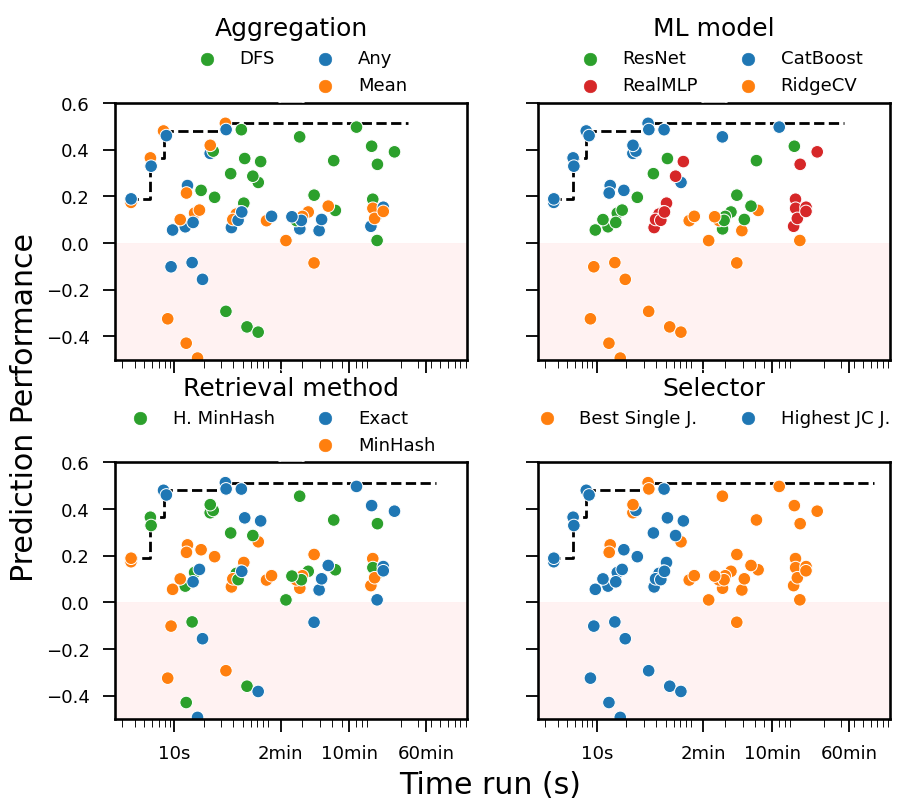

In [27]:
fig, axs = plt.subplots(2, 2, squeeze=True, sharey=True, sharex=True, figsize=(10, 8), gridspec_kw={"hspace":.4} )

# axs[0].set_xscale("log")
# axs[0].set_ylabel("Prediction performance")

variable = "time_run"
x = res[variable]
y = res["y"]
y_var = "y"

hue_order = {
    "estimator": ["highest_containment","best_single_join"],
    "chosen_model": ["catboost", "ridgecv", "resnet", "realmlp"],
    "jd_method": ["exact_matching", "minhash", "minhash_hybrid"],
    "aggregation": ["first", "mean", "dfs"],
}


groups = ["aggregation", "chosen_model", "jd_method", "estimator"]
for pl_id in range(4):
    group_variable = groups[pl_id]
    ax = axs[pl_id//2][pl_id%2]
    ax.set_xscale("log")
    idx_ = pl_id
    h, l = plotting.pareto_frontier_plot(
        data,
        variable,
        y_var,
        hue_var=group_variable,
        palette="tab10",
        hue_order=hue_order[group_variable],
        ax=ax,
        ax_title="",
        ax_xlabel="",
    )
    l = [constants.LABEL_MAPPING[groups[pl_id]][_] for _ in l]

    ax.legend(
        h,
        l,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.4),
        title=constants.LABEL_MAPPING["variables"][groups[pl_id]],
        ncols= 2,
        mode="expand",
        edgecolor="white",
        # columnspacing=50
    )
    ax.xaxis.set_major_formatter(major_time_formatter)
    ax.xaxis.set_major_locator(major_time_locator)

fig.supylabel("Prediction Performance")
fig.supxlabel("Time run (s)")


Text(0.5, 0.01, 'Time run (s)')

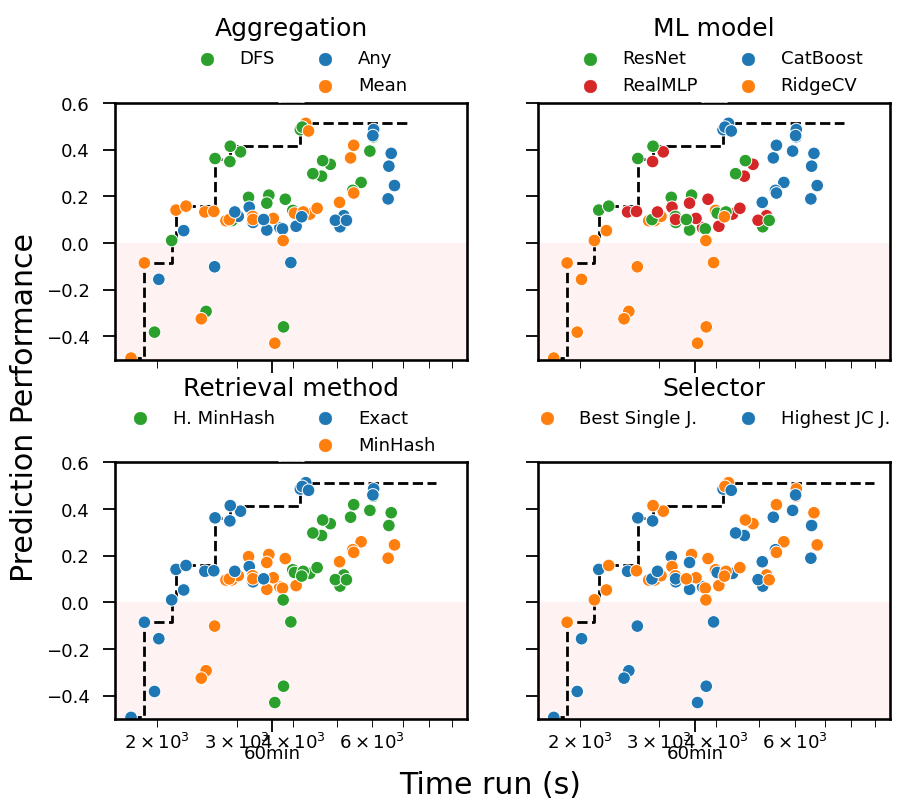

In [28]:
fig, axs = plt.subplots(2, 2, squeeze=True, sharey=True, sharex=True, figsize=(10, 8), gridspec_kw={"hspace":.4} )

# axs[0].set_xscale("log")
# axs[0].set_ylabel("Prediction performance")

variable = "peak_fit"
x = res[variable]
y = res["y"]
y_var = "y"

hue_order = {
    "estimator": ["highest_containment","best_single_join"],
    "chosen_model": ["catboost", "ridgecv", "resnet", "realmlp"],
    "jd_method": ["exact_matching", "minhash", "minhash_hybrid"],
    "aggregation": ["first", "mean", "dfs"],
}


groups = ["aggregation", "chosen_model", "jd_method", "estimator"]
for pl_id in range(4):
    group_variable = groups[pl_id]
    ax = axs[pl_id//2][pl_id%2]
    ax.set_xscale("log")
    idx_ = pl_id
    h, l = plotting.pareto_frontier_plot(
        data,
        variable,
        y_var,
        hue_var=group_variable,
        palette="tab10",
        hue_order=hue_order[group_variable],
        ax=ax,
        ax_title="",
        ax_xlabel="",
    )
    l = [constants.LABEL_MAPPING[groups[pl_id]][_] for _ in l]

    ax.legend(
        h,
        l,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.4),
        title=constants.LABEL_MAPPING["variables"][groups[pl_id]],
        ncols= 2,
        mode="expand",
        edgecolor="white",
        # columnspacing=50
    )
    ax.xaxis.set_major_formatter(major_time_formatter)
    ax.xaxis.set_major_locator(major_time_locator)

fig.supylabel("Prediction Performance")
fig.supxlabel("Time run (s)")


In [29]:
data

,jd_method,estimator,aggregation,chosen_model,y,time_run,peak_fit
0,minhash,best_single_join,dfs,resnet,0.205010,262.785614,3537.520182
1,minhash,highest_containment,dfs,realmlp,0.170748,50.905262,3500.374000
2,exact_matching,highest_containment,dfs,realmlp,0.348963,75.432263,2898.841368
3,minhash_hybrid,best_single_join,first,catboost,0.384038,23.223157,6606.440511
4,minhash,highest_containment,first,realmlp,0.066118,38.117533,3740.581462
...,...,...,...,...,...,...,...
67,minhash_hybrid,best_single_join,first,ridgecv,0.112476,156.461893,4183.120622
68,minhash_hybrid,best_single_join,mean,catboost,0.418623,23.268916,5454.888002
69,minhash,highest_containment,mean,ridgecv,-0.324873,8.619663,2505.516276
70,exact_matching,highest_containment,first,catboost,0.460218,8.353556,6015.628288
